In [4]:
import requests
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import time
import datetime as dt
import hvplot.pandas
%matplotlib inline

## Prepare Data
The final data frame data consists of four seperate csv file, concatenated and merged by their keys, ideally this would be done in an SQL db.

In [5]:
# read circuits, slice for nessecary data
circuits = pd.read_csv('f1db_csv/circuits.csv')
circuits = circuits[['circuitId', 'name']].set_index('circuitId')

# read standings data, groupby unique identifiers for concat (sum wins for extra analysis)
standings = pd.read_csv('f1db_csv/driver_standings.csv')
standings = standings.groupby(['raceId', 'driverId']).sum('wins')

# read pit_stops, groupby keys to get unique pit times for each driver during each race, sum to get total pit time.
pit_stops = pd.read_csv('f1db_csv/pit_stops.csv')
pit_stops = pit_stops.groupby(['raceId', 'driverId']).sum().drop(columns=['stop', 'lap'])

# read races csv, for some reason this data contains columns with lots of null data and the column names are offset, 
# so the original csv was edited in excel to remove these columns.
races = pd.read_csv('f1db_csv/races_edited.csv').set_index('raceId')

# concat pit_stops and standings by index, ensuring that raceId and driverId are the same
data = pd.concat([pit_stops, standings], join='inner', axis='columns')

# filter by total sum of pit time <500000 ms, removing outliers and excessivly long pit times.
data = data[data['milliseconds']<500000]

# remove multi indexing
data = data.reset_index()

# left merge data with races by raceId, and reset_index, slice to use only nessecary data.
data = data.merge(races, on='raceId' , how='left').reset_index()
data = data[['raceId', 'driverId', 'milliseconds', 'driverStandingsId', 'circuitId', 'position']]

# left merge data with circuits, by circuitId
data = data.merge(circuits, on='circuitId', how='left')
data

,raceId,driverId,milliseconds,driverStandingsId,circuitId,position,name
0,841,1,46426,64691,1,2,Albert Park Grand Prix Circuit
1,841,2,48092,64701,1,12,Albert Park Grand Prix Circuit
2,841,3,23716,64706,1,17,Albert Park Grand Prix Circuit
3,841,4,72165,64693,1,4,Albert Park Grand Prix Circuit
4,841,5,24865,64707,1,18,Albert Park Grand Prix Circuit
...,...,...,...,...,...,...,...
4091,1075,844,21038,71272,77,1,Jeddah Corniche Circuit
4092,1075,846,20383,71286,77,10,Jeddah Corniche Circuit
4093,1075,847,21415,71275,77,4,Jeddah Corniche Circuit
4094,1075,848,20683,71284,77,18,Jeddah Corniche Circuit


## API Call functions

In [12]:
def ergast_get_standings(year, race):
    '''call ergast api to get driver standings for a giver year and race number'''
    url = f'http://ergast.com/api/f1/{year}/{race}/driverStandings.json'
    data = requests.get(url).json()

    standings = {}

    # parse json object and retrieve standings
    for x, driver in enumerate(data['MRData']['StandingsTable']['StandingsLists'][0]['DriverStandings']):
        position = driver['position']
        driver_id = driver['Driver']['driverId']
        standings[driver_id] = position
    
    # conver to df, rename the column and change data type
    standings = pd.DataFrame.from_dict(standings, orient='index').rename(columns={0:'standing'}).apply(pd.to_numeric)
    
    return standings

def ergast_get_pitstops(year, race):
    '''
    call ergast api to get pitstops for a given year and race number.
    returns a pandas dataframe containing pitstops for each race of the event for each driver.
    '''

    # call API and get json object response
    url = f'http://ergast.com/api/f1/{year}/{race}/pitstops.json'
    data = requests.get(url).json()

    # empty data to append data to in the case that there are > 1 'Races' in the json object
    pitstops = pd.DataFrame()

    # parse Json object to obtain the pitstops table.
    for x, race in enumerate(data['MRData']['RaceTable']['Races']):
        pit_stops = pd.DataFrame(race['PitStops']).set_index('driverId')
        pitstops = pitstops.append(pit_stops)

    return pitstops

def ergast_get_races(year):
    url = f'http://ergast.com/api/f1/{year}/races.json'
    data = requests.get(url).json()

    race_list = []
    
    for x, race in enumerate(data['MRData']['RaceTable']['Races']):
        race_list.append(race['round'])

    return race_list

def time_to_next_race():
    # call api for current season
    url = 'http://ergast.com/api/f1/current.json'
    data = requests.get(url).json()
    
    #get today's date
    today = dt.date.today().isoformat()
    
    # get the date of the previous and next race
    for race in data['MRData']['RaceTable']['Races']:
        if dt.datetime.strptime(race['date'],'%Y-%m-%d').isoformat() < today:
            previous_race = dt.datetime.strptime(race['date'],'%Y-%m-%d').isoformat()
        else:
            next_race = dt.datetime.strptime(race['date'],'%Y-%m-%d').isoformat()
            break
            
    # convert dates to numbers
    previous_race = dt.datetime.fromisoformat(previous_race).timestamp()
    next_race = dt.datetime.fromisoformat(next_race).timestamp()
    now = dt.datetime.fromisoformat(today).timestamp()
    
    #calculate the percentage time till the next race from the previous race.
    pct_ttnr = round((((now-previous_race)/(next_race-previous_race)))*100, 2)
    
    return pct_ttnr

def pit_pos():
    # take the average pit time for top 20 positions and plot with trendline (data becomes thin after the top 20)
    avg_pt_for_position = data.groupby('position').mean().reset_index().head(20)
    scatter = px.scatter(avg_pt_for_position, x='position', y='milliseconds', trendline="ols")
    return scatter

def pit_pos_tracks():
    data_by_tracks = data.groupby(['name','position']).mean().reset_index()
    scatter = data_by_tracks.hvplot.scatter(x='position', y='milliseconds', groupby='name')
    return scatter

def pit_time_histogram():
    # multimodal data can be attributed to the modes of pit times ie: 1 stop for entire race vs 2 or 3 stops etc...
    histogram = data.hvplot.hist(y='milliseconds',bins = 200, height=500, width=900)
    return histogram

In [13]:
pit_time_histogram()

:Histogram   [milliseconds]   (milliseconds_count)

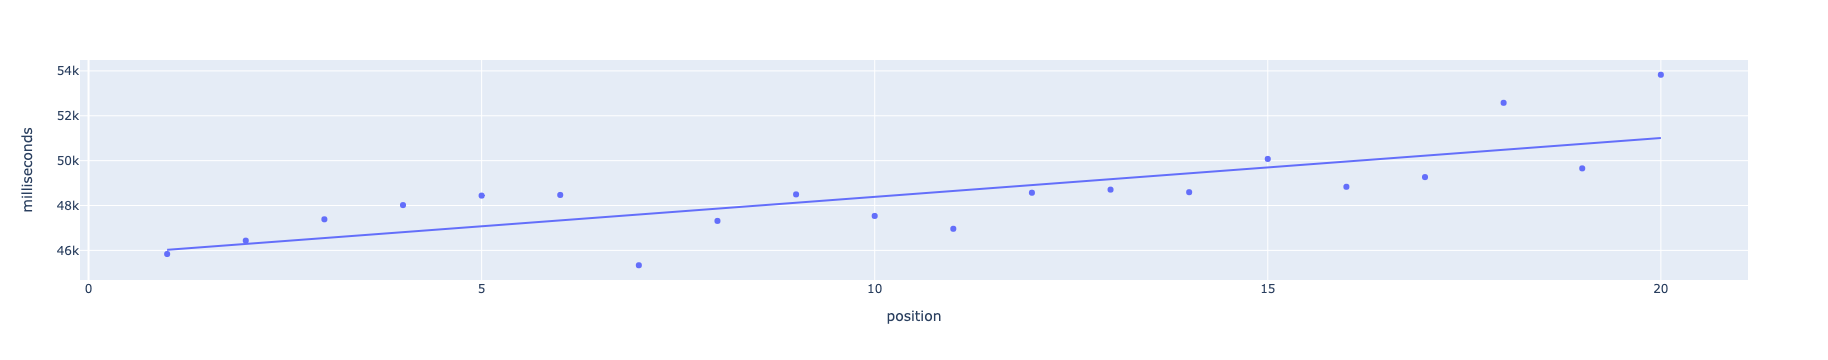

In [12]:
pit_pos()

## Is this causation or just correlation?
Although the trendline appears to indicate some level of correlation between pit time and final position, it is unclear if this relationship is causal. There are many factors that go into pitstops, including strategy, tracklayout, weather conditions etc. This correlation however, may indicate that teams with lower pit times are somewhat better at coordinating a team for higher win rates, and therefore pit times are a good indicator for a teams overall success.

In [13]:
pit_pos_tracks()

:DynamicMap   [name]
   :Scatter   [position]   (milliseconds)

## Track analysis
- Albert Park - minimise pit times, with caution not to let car performance suffer.
- Monaco, Marina bay - minimise pit times
- Hockenheimring, Sepang itnl - no correlation, prioritise car performance
- Huangoring - Interesting shape
- Catalunya - consistent, maybe present an opportunity for a team to innovate with pit strategy